# Gapfilling performance measure after Sco and Universal gapfill

In [9]:
import cobra
from cobra.io import read_sbml_model, load_json_model
import os
import pandas as pd

pd.set_option("display.max_columns", 20)

print(os.getcwd())

ext_dir = '/../../../data/external'
phenomics = '/../../phenomics'
gapfilling = '/../gapfilling'

/Users/te/Library/CloudStorage/OneDrive-Personal/Biosustain/strep/Code/streptsd/notebooks/gapfilling/2.gapfill_w_universal


# Calculate activity based on biolog data

In [10]:
# Mapping of bigg and biolog model
bigg_map_dir = os.getcwd() + ext_dir + "/" + "biolog_bigg_map.csv"
biolog_bigg_map = pd.read_csv(bigg_map_dir)

# Import processed biolog data based on DuctApe result
bio_data_dir = os.getcwd() + phenomics + "/" + 'phenome_J1074.tsv'
bio_data = pd.read_table(bio_data_dir)

In [11]:
# Join two tables together
bio_data.rename(columns={"#plate_id": "plate_id"}, inplace=True)
bio_data['index'] = bio_data['plate_id'] + "_" + bio_data['well_id']

biolog_bigg_map.rename(columns={"#plate_id": "plate_id"}, inplace=True)
bio_data_merged = bio_data.merge(biolog_bigg_map[['index', 'bigg', 'exchange']], on='index', how='left')

bio_data_merged

,plate_id,well_id,chemical,category,moa,co_id,replica,activity,min,max,height,plateau,slope,lag,area,source,index,bigg,exchange
0,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
1,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,2,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
2,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,3,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
3,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,1,9,0.1,230.173474,186.348403,230.400043,12.071765,1.053133,13196.559443,DuctApe,PM01_A02,arab__L,EX_arab__L_e
4,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,2,9,0.1,238.758221,193.692816,234.428667,23.269590,5.473487,13715.757651,DuctApe,PM01_A02,arab__L,EX_arab__L_e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,PM04,H11,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",C11145,2,0,0.1,8.549399,1.866640,0.000000,0.000000,0.000000,132.497394,DuctApe,PM04_H11,mso3,EX_mso3_e
1148,PM04,H11,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",C11145,3,0,0.1,6.706928,1.168076,1.085922,1.687639,0.591895,83.150410,DuctApe,PM04_H11,mso3,EX_mso3_e
1149,PM04,H12,Tetramethylene Sulfone,phosphate & sulphur,"S-Source, organic",NaN,1,0,0.1,26.160836,4.513821,0.000000,0.000000,0.000000,319.593733,DuctApe,PM04_H12,#,#
1150,PM04,H12,Tetramethylene Sulfone,phosphate & sulphur,"S-Source, organic",NaN,2,0,0.1,20.141574,4.671340,0.000000,0.000000,0.000000,328.952628,DuctApe,PM04_H12,#,#


In [12]:
# Find out the samples that grow or not grow based on activity and replicas
# Vote: >=3 = growth, >2/3 replicates = grow

def calculate_agreed_activity(bio_data, activity_cutoff=3, num_agreed_replicas=2):
    """
    Based on the activity data from the microarray experiment, using activity cutoff and
    agreed number replicates cutoff to make a dataframe that contains final activity info.
    
    Input:
    activity_cutoff: an integer between 0-9, if the activity is more than cutoff, it 
    means the strain grows.
    num_agreed_replicas: an integer, if the number of replicates agrees more than
    num_agreed_replicas times, it means the replicas agrees with the experimental result.
    
    Output:
    A dataframe that
    """
    agreed_bio_data = pd.DataFrame(columns=[
    'index', 'activity', 'chemical', 'category', 'moa', 'bigg', 'exchange'])
    
    # for each column 'index'
    for index, group in bio_data.groupby('index'):
        first_row = group.iloc[0]
        if (group['activity'] >= activity_cutoff).sum() >= num_agreed_replicas:
            agreed_bio_data = agreed_bio_data.append({'index': index, 
                                    'activity': True, 
                                    'chemical': first_row['chemical'], 
                                    'category':  first_row['category'], 
                                    'moa':  first_row['moa'],
                                    'bigg': first_row['bigg'],
                                    'exchange': first_row['exchange']}, ignore_index=True)
        else:
            agreed_bio_data = agreed_bio_data.append({'index': index, 
                                    'activity': False, 
                                    'chemical': first_row['chemical'], 
                                    'category':  first_row['category'], 
                                    'moa':  first_row['moa'],
                                    'bigg': first_row['bigg'],
                                    'exchange': first_row['exchange']}, ignore_index=True)
    return agreed_bio_data


activity_cutoff = 3
num_agreed_replicas = 2
agreed_bio_data = calculate_agreed_activity(bio_data_merged, activity_cutoff, num_agreed_replicas)

/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_57352/1067062907.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_57352/1067062907.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_57352/1067062907.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_57352/1067062907.py:25: FutureWarning: The frame.append method is depreca

# Test model simulations

In [13]:
# Import model
model_path = os.getcwd() + "/" + "Salb-GEM-Uni-gapfill.xml"
model = read_sbml_model(model_path)


'' is not a valid SBML 'SId'.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-13


In [14]:
# Define media and model simulation functions
media = {
    "Biolog_base": {  # based on ecocyc
        "EX_cl_e": -1000,
        "EX_na1_e": -1000,
        "EX_nh4_e": -1000,
        "EX_pi_e": -1000,
        "EX_k_e": -1000,
        "EX_so4_e": -1000,
        "EX_mg2_e": -1000,
        "EX_fe2_e": -1000,
        # based on conditions, essentials and trace requirements
        "EX_o2_e": -1000,
        "EX_co2_e": -1000.0,
        "EX_h_e": -1000.0,
        "EX_mn2_e": -1000.0,
        "EX_zn2_e": -1000.0,
        "EX_ca2_e": -1000.0,
        "EX_ni2_e": -1000.0,
        "EX_cu2_e": -1000.0,
        "EX_cobalt2_e": -1000.0,
        "EX_h2o_e": -1000.0,
        "EX_mobd_e": -1000.0,
    },
    "C-Source": {},  # no further modification is needed
    "N-Source": {  # remove ammonia and add C-source
        "EX_nh4_e": 0,
        "EX_pyr_e": -20,
    },
    "P-Source": {  # remove phosphate and add C-source
        "EX_pi_e": 0,
        "EX_pyr_e": -20,
    },
    "S-Source": {  # remove sulfate and add C-source
        "EX_so4_e": 0,
        "EX_pyr_e": -20,
    },
}

def test_model_wrt_biolog(
    moa: str,
    additional_exchange: str,
    model: cobra.core.Model,
    media: dict = media,
    cutoff: float = 0.05,
):
    """
    Tests model with given media and returns True/False based on cutoff growth rate.
    If additional exchange reaction is not in the model, returns NaN.

    Input
    model: metabolic model
    moa: the mechanism of action of the biolog well test
    additional_exchange: the exchange reaction to be added to the model for the well
    media: a dictionary of media conditions to set for a given biolog test
    cutoff: the cutoff growth rate for boolean return

    Output
    True/False based on cutoff growth rate or NaN if additional exchange reaction is not
     in the model
    """
    # drop out quickly if there is no exchange reaction to use in the model
    if additional_exchange not in model.reactions:
        return float("nan")

    with model:
        # reset original media
        for exchange in model.medium.keys():
            model.reactions.get_by_id(exchange).lower_bound = 0

        # set base media
        for exchange, value in media["Biolog_base"].items():
            model.reactions.get_by_id(exchange).lower_bound = value

        for exchange, value in media[moa.split(",")[0]].items():
            model.reactions.get_by_id(exchange).lower_bound = value

        # add exchange reaction. lower bound is high but we are only looking for T/F/NAN
        model.reactions.get_by_id(additional_exchange).lower_bound = -20

        # solve and return
        return True if (model.slim_optimize(error_value=0) >= cutoff) else False

AttributeError: module 'cobra' has no attribute 'core'

In [ ]:
# Test the model to see if the biolog growth matches with simulation runs
# simulation cutoff 
sim_cutoff = [0.05, 0.1, 0.2]

for s in sim_cutoff:
    agreed_bio_data["model_simulation" + "_" + str(s)] = agreed_bio_data.apply(
        func=lambda row: test_model_wrt_biolog(
            moa=row["moa"],
            additional_exchange=row["exchange"],
            model=model,
            media=media,
            cutoff=s,
        ),
        axis=1,
    )


In [ ]:
# Determine the TP, FP, TN and FN

def pred_vs_actual(bio_data, actual, predicted):
    """
    This is a function that summarizes the growth activities by comparing simulated model 
    and actual experimental values.
    
    Input:
    bio_data: A dataframe that contains one column of model siumlation and one column 
    of actual activity.
    actual: A string that is the column name of experimental activity level.
    predicted: A string that is the column name of model value.
    
    Output:
    A 2 by 2 dataframe that that contains the sum of matched True/False values.
    
    """
    return pd.crosstab(bio_data[actual], bio_data[predicted], rownames=['Actual'], colnames=['Predicted'])


# cutoff 0.05
confusion_matrix_005 = pd.crosstab(agreed_bio_data['activity'], agreed_bio_data['model_simulation_0.05'], rownames=['Actual'], colnames=['Predicted'])
print("cutoff 0.05\n", confusion_matrix_005)

# cutoff 0.1
confusion_matrix_01 = pd.crosstab(agreed_bio_data['activity'], agreed_bio_data['model_simulation_0.1'], rownames=['Actual'], colnames=['Predicted'])
print("\ncutoff 0.1\n", confusion_matrix_01)

# cutoff 0.2
confusion_matrix_02 = pd.crosstab(agreed_bio_data['activity'], agreed_bio_data['model_simulation_0.2'], rownames=['Actual'], colnames=['Predicted'])
print("\ncutoff 0.2\n", confusion_matrix_02)


cm_list = [confusion_matrix_005, confusion_matrix_01, confusion_matrix_02]

cutoff 0.05
 Predicted  False  True 
Actual                 
False          3     26
True           0    103

cutoff 0.1
 Predicted  False  True 
Actual                 
False          3     26
True           0    103

cutoff 0.2
 Predicted  False  True 
Actual                 
False          3     26
True           0    103


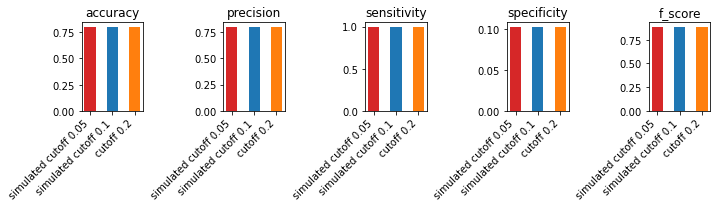

In [ ]:
import matplotlib.pyplot as plt

# calculate accuracy, precision, sensitivity, specificity, and f-Score for each confusion matrix
# plot all the result into a graph
def calculate_stats(confusion_matrix):
    """
    Description: A function that automatically calculate 5 essential statistics
    
    Input: 
    confusion_matrix: A 2 by 2 dataframe. It's a confusion matrix with row being 
    actual and column being predicted.
    
    Output: 
    result: A dictionary of essential statistics, including accuracy, precision, sensitivity, 
    specificity, f score. 
    """
    result = {}

    result['TN'] = tn = confusion_matrix.iloc[0, 0]
    result['FP'] = fp = confusion_matrix.iloc[0, 1]
    result['FN'] = fn = confusion_matrix.iloc[1, 0]
    result['TP'] = tp = confusion_matrix.iloc[1, 1]

    result['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    result['precision'] = precision = tp / (tp + fp)
    result['sensitivity'] = sensitivity = tp / (tp + fn)
    result['specificity'] = tn / (tn + fp)
    result['f_score'] = 2 * (precision * sensitivity) / (precision + sensitivity)

    return result


stats_005 = calculate_stats(confusion_matrix_005)
stats_01 = calculate_stats(confusion_matrix_01)
stats_02 = calculate_stats(confusion_matrix_02)

plt.figure(figsize=(10, 3)) 
x = [1, 2, 3]
labels = ['accuracy', 'precision', 'sensitivity', 'specificity', 'f_score']
for i, key in enumerate(labels):
    y = [stats_005[key], stats_01[key], stats_02[key]]
    plt.subplot(1, 5, i + 1)
    plt.bar(x, y, width=0.5, color=['tab:red', 'tab:blue', 'tab:orange'])
    plt.title(key)
    plt.xticks(x, ['simulated cutoff 0.05', 'simulated cutoff 0.1', 'cutoff 0.2'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Compare different activity cutoff

/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_88084/1067062907.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_88084/1067062907.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_88084/1067062907.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  agreed_bio_data = agreed_bio_data.append({'index': index,
/var/folders/wy/8d18n83n56j78d4j6zkz449m0000gn/T/ipykernel_88084/1067062907.py:25: FutureWarning: The frame.append method is depreca

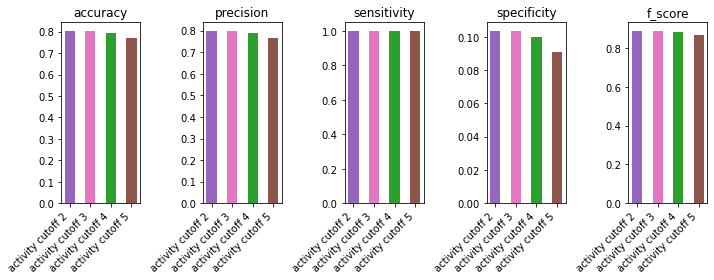

In [ ]:
# Since we have found out that the simulated activity cutoff 0.05, 0.1 and 0.2 doesn't have much difference, 
# we now compare if actual activity cutoff will affect the final result
agreed_activity_data_3 = calculate_agreed_activity(bio_data_merged, 3, 2)
agreed_activity_data_3['model_simulation_0.05'] = agreed_bio_data['model_simulation_0.05']
confusion_matrix_3 = pred_vs_actual(agreed_activity_data_3, "activity", "model_simulation_0.05")
result_3 = calculate_stats(confusion_matrix_3)


agreed_activity_data_4 = calculate_agreed_activity(bio_data_merged, 4, 2)
agreed_activity_data_4['model_simulation_0.05'] = agreed_bio_data['model_simulation_0.05']
confusion_matrix_4 = pred_vs_actual(agreed_activity_data_4, "activity", "model_simulation_0.05")
result_4 = calculate_stats(confusion_matrix_4)

agreed_activity_data_5 = calculate_agreed_activity(bio_data_merged, 5, 2)
agreed_activity_data_5['model_simulation_0.05'] = agreed_bio_data['model_simulation_0.05']
confusion_matrix_5 = pred_vs_actual(agreed_activity_data_5, "activity", "model_simulation_0.05")
result_5 = calculate_stats(confusion_matrix_5)

plt.figure(figsize=(10, 4)) 
x = [1, 2, 3, 4]
labels = ['accuracy', 'precision', 'sensitivity', 'specificity', 'f_score']
for i, key in enumerate(labels):
    y = [stats_005[key], result_3[key], result_4[key], result_5[key]]
    plt.subplot(1, 5, i + 1)
    plt.bar(x, y, width=0.5, color=['tab:purple', 'tab:pink', 'tab:green', 'tab:brown'])
    plt.title(key)
    plt.xticks(x, ['activity cutoff 2', 'activity cutoff 3', 'activity cutoff 4', 'activity cutoff 5'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

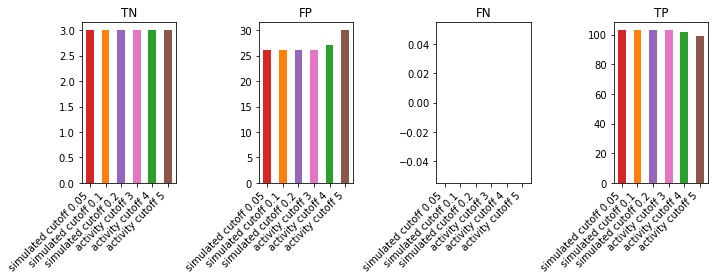

In [ ]:
# Now it's time to show the full result
cm_list = [confusion_matrix_005, confusion_matrix_01, confusion_matrix_02, confusion_matrix_3, confusion_matrix_4, confusion_matrix_5]
full_result = pd.DataFrame([calculate_stats(x) for x in cm_list])
full_result['simulated_cutoff'] = [0.05, 0.1, 0.2, 0.05, 0.05, 0.05]
full_result['activity_cutoff'] = [2, 2, 2, 3, 4, 5]


plt.figure(figsize=(10, 4)) 
x = [1, 2, 3, 4, 5, 6]
labels = ['TN', 'FP', 'FN', 'TP']
for i, key in enumerate(labels):
    y = full_result[key]
    plt.subplot(1, 4, i + 1)
    plt.bar(x, y, width=0.5, color=['tab:red', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:green', 'tab:brown'])
    plt.title(key)
    plt.xticks(x, ['simulated cutoff 0.05', 'simulated cutoff 0.1', 'simulated cutoff 0.2', 'activity cutoff 3', 'activity cutoff 4', 'activity cutoff 5'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Testability of the model

In [ ]:
agreed_bio_data

,index,activity,chemical,category,moa,bigg,exchange,model_simulation_0.05,model_simulation_0.1,model_simulation_0.2
0,PM01_A01,False,Negative Control,carbon,"C-Source, negative control",#,#,NaN,NaN,NaN
1,PM01_A02,True,L-Arabinose,carbon,"C-Source, carbohydrate",arab__L,EX_arab__L_e,True,True,True
2,PM01_A03,True,N-Acetyl-D-Glucosamine,carbon,"C-Source, carbohydrate",acgam,EX_acgam_e,NaN,NaN,NaN
3,PM01_A04,False,D-Saccharic acid,carbon,"C-Source, carboxylic acid",glcr,EX_glcr_e,NaN,NaN,NaN
4,PM01_A05,True,Succinic acid,carbon,"C-Source, carboxylic acid",succ,EX_succ_e,True,True,True
...,...,...,...,...,...,...,...,...,...,...
379,PM04_H08,False,p-Aminobenzene Sulfonic acid,phosphate & sulphur,"S-Source, organic",4abz,EX_4abz_e,NaN,NaN,NaN
380,PM04_H09,False,Butane Sulfonic acid,phosphate & sulphur,"S-Source, organic",butso3,EX_butso3_e,NaN,NaN,NaN
381,PM04_H10,False,2-Hydroxyethane Sulfonic acid,phosphate & sulphur,"S-Source, organic",isetac,EX_isetac_e,NaN,NaN,NaN
382,PM04_H11,False,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",mso3,EX_mso3_e,NaN,NaN,NaN


In [ ]:
# Find out the testable & untestable number of sources from simulation
for element in "CNPS":
    num1 = len(
        agreed_bio_data[
            (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
            & ~(agreed_bio_data.xs("model_simulation_0.05", axis=1).isna())
        ]
    )
    num2 = len(
        agreed_bio_data[
            (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
            & (agreed_bio_data.xs("model_simulation_0.05", axis=1).isna())
        ]
    )
    print(f"{element}-sources: Number of computationally testable: {num1} and untestable: {num2}")

C-sources: Number of computationally testable: 68 and untestable: 124
N-sources: Number of computationally testable: 45 and untestable: 51
P-sources: Number of computationally testable: 15 and untestable: 45
S-sources: Number of computationally testable: 4 and untestable: 32


In [ ]:
# Find out the untestable ones
count = 0
for element in "CNPS":
    chemicals = agreed_bio_data[
        (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
        & (agreed_bio_data.xs("model_simulation_0.05", axis=1).isna())
        & (agreed_bio_data.xs("activity", axis=1))
    ]["chemical"].unique()
    count += len(chemicals)
    
    print(f"{element}-sources: \nUntestable chemicals with positive growth in experiment: \n{chemicals}\n")
print(count)

C-sources: 
Untestable chemicals with positive growth in experiment: 
['N-Acetyl-D-Glucosamine' 'DL-Malic acid' 'Tween 20' 'D-Glucosaminic acid'
 'Tween 40' 'a-Ketobutyric acid' 'Tween 80' 'a-Hydroxybutyric acid'
 'b-Methyl-D-Glucoside' 'Gly-Asp' 'Bromosuccinic acid' 'Glyoxylic acid'
 'Gly-Glu' 'Ala-Gly' 'Methylpyruvate' 'Gly-Pro'
 'm-Hydroxyphenyl Acetic acid' 'g-Cyclodextrin' 'Dextrin' 'Gelatin'
 'Glycogen' 'Laminarin' 'Amygdalin' 'D-Arabinose' 'Arbutin' 'Gentiobiose'
 'Salicin' 'Butyric acid' 'Caproic acid' 'D-Glucosamine' 'Malonic acid'
 'L-Alaninamide']

N-sources: 
Untestable chemicals with positive growth in experiment: 
['Biuret' 'D-Asparagine' 'D-Valine' 'N-Phthaloyl-L-Glutamic acid'
 'L-Pyroglutamic acid' 'Agmatine' 'b-Phenylethylamine' 'Tyramine'
 'Acetamide' 'Formamide' 'Glucuronamide' 'DL-Lactamide' 'D-Glucosamine'
 'D-Mannosamine' 'N-Acetyl-D-Glucosamine' 'N-Acetyl-D-Galactosamine'
 'N-Acetyl-D-Mannosamine' 'Uric acid' 'Alloxan' 'Allantoin'
 'Parabanic acid' 'DL-a-Amino-N

# Find out false positives & negatives

In [ ]:
# Find out the inconsistency between predicted and simulated ones
print(f"False positives (actual false, predicted true):\n")
print(agreed_bio_data[
    ~(agreed_bio_data.xs("activity", axis=1))
    & agreed_bio_data.xs("model_simulation_0.05", axis=1)
    ]["chemical"].unique())



False positives (actual false, predicted true):

['D-Alanine' 'D-Trehalose' 'D-Serine' 'D-Sorbitol'
 'DL-a-Glycerol Phosphate' 'Formic acid' 'L-Rhamnose' 'D-Melibiose'
 'a-Ketoglutaric acid' 'Uridine' 'L-Glutamine' 'm-Inositol'
 'Glycolic acid' '2-Aminoethanol' 'D-Raffinose' 'Xylitol'
 'g-Amino-N-Butyric acid' 'D-Tartaric acid' 'L-Arginine' 'L-Homoserine'
 'L-Leucine' 'L-Lysine' 'L-Ornithine' 'Guanine'
 'Cytidine 3`-Monophosphate' 'Sulfate']


In [ ]:
print(f"\nFalse negative (actual true, predicted false):\n")
agreed_bio_data_nan_drop = agreed_bio_data[agreed_bio_data['model_simulation_0.05'].notna()]
false_negative = agreed_bio_data_nan_drop[
    agreed_bio_data_nan_drop.xs("activity", axis=1)
    & ~(agreed_bio_data_nan_drop.xs("model_simulation_0.05", axis=1))
    ]["chemical"].unique()

print(false_negative)


False negative (actual true, predicted false):

[]


In [ ]:
agreed_bio_data.to_csv(os.getcwd() + "/" + 'agreed_bio_data_Salb_Sco.csv', index=False)